In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanerzer","key":"6a738120362e1d0ee8a395b5fc9a6333"}'}

In [ ]:
!ls -lha kaggle.json

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 64 May 22 10:21 kaggle.json


In [ ]:
!kaggle datasets download -d abhikjha/utk-face-cropped

 99% 229M/232M [00:03<00:00, 64.1MB/s]
100% 232M/232M [00:03<00:00, 78.8MB/s]


In [ ]:
!ls

drive  kaggle.json  sample_data  utk-face-cropped.zip


In [ ]:
!unzip utk-face-cropped.zip

In [ ]:
!ls

drive  kaggle.json  sample_data  utkcropped  utk-face-cropped.zip


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2

wd = os.getcwd()
path = os.path.join(wd, "utkcropped/utkcropped")
files = os.listdir(path)
size = len(files)
print("Veri sayisi", size)

Veri sayisi 23709


In [ ]:
age = [i.split('_')[0] for i in files]

In [ ]:
values, counts = np.unique(age, return_counts=True)
print(counts)

[1123  156   11    2    1    5   65    5    1    3    4  130   81  157
  177  247  158  262   98  482  284  346  395  426  859  734 2197  615
  918  570  289  724  350  664  143  409  880  483  293  325  266  273
  526  132  266  157  100  440  153  170  153  148  196  381  138  232
  241  353  268  236   97  271   82  131  293  162  125  103   50  259
   77   94  100   56  139  147   33   98   63   32  148   58   28   69
   23  263  133   22   40   18   24  155   35   10   34   33  166   82
    2   13    5    9   17    9]


In [ ]:
classes = []
for i in age:
    i = int(i)
    if i<=18:
        classes.append(0)
    elif i<=65:
        classes.append(1)
    elif i>65: 
        classes.append(2)                      

In [ ]:
len(classes)

23709

In [ ]:
values, counts = np.unique(classes, return_counts=True)
print(counts)

[ 4495 17515  1699]


In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
age_categorical_labels = to_categorical(classes, num_classes=3)
age_categorical_labels[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
images=[]
i=0
for file in files:
  total=path+'/'+file
  print(total," i:",i)
  i=i+1
  image=cv2.imread(total)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image= cv2.resize(image,(64,64))
  images.append(image)

In [ ]:
x_data=np.array(images)
x_data.shape

(23709, 64, 64, 3)

In [ ]:
x = np.squeeze(x_data)
x = x.astype('float32')
x /= 255
x.shape

(23709, 64, 64, 3)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_valid, y_train, y_test = train_test_split(x, age_categorical_labels, test_size=0.2)
X_valid , X_test, y_valid, y_test = train_test_split(X_valid, y_test, test_size=0.5)

In [ ]:
print("X_train", X_train.shape)
print("X_valid", X_valid.shape)
print("X_test", X_test.shape)

X_train (18967, 64, 64, 3)
X_valid (2371, 64, 64, 3)
X_test (2371, 64, 64, 3)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
            width_shift_range=.15,
            height_shift_range=.15,
            rotation_range=15,
            horizontal_flip=True,
            zoom_range=[0.5,1.0])

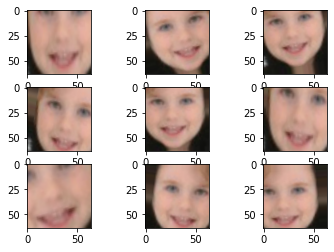

<Figure size 432x288 with 0 Axes>

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def plot_augmentation(image):
    data = img_to_array(image)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    image_gen = ImageDataGenerator(
            width_shift_range=.15,
            height_shift_range=.15,
            rotation_range=15,
            horizontal_flip=True,
            zoom_range=[0.5,1.0])
    # prepare iterator
    it = image_gen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(9):
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        plt.imshow(image)
    # show the figure
    plt.show()
    plt.savefig('augmentation_demo.png', dpi = 300, bbox_inches='tight')
    
    
plot_augmentation(images[32])

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense,Conv2D,Activation,MaxPool2D,Flatten,Dropout,BatchNormalization,Input
from keras.utils import np_utils
from keras_preprocessing import image
from keras.callbacks import ModelCheckpoint

In [ ]:
model=Sequential()
#1.katman
model.add(Conv2D(64, 3, input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2.katman
model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.5)) # %50 unutma işlemi

#3.katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))

#4.katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))

#5.katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.5)) # %50 unutma işlemi

#tam baglanti katmani
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))  # %60 unutma işlemi

#cıkış katmanı
model.add(Dense(3))
model.add(Activation("softmax")) #sınıflama işlemi 

#optimazyon basarım metrikleri
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

model.summary() #modelin özeti


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0

In [ ]:
root="/gdrive/My Drive/Kaggle/"

In [ ]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath=root + 'data/age_face_model.h5', verbose=1, save_best_only=True)

epochs = 50
batchSize = 100 

# modeli çalıştır
hist = model.fit(X_train, y_train, 
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize, 
                 validation_data=(X_valid, y_valid),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open(root + "data/age_face_model.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/50
190/190 - 44s - loss: 0.6653 - accuracy: 0.7593 - val_loss: 0.8023 - val_accuracy: 0.7474

Epoch 00001: val_loss improved from inf to 0.80233, saving model to /gdrive/My Drive/Kaggle/data/age_face_model.h5
Epoch 2/50
190/190 - 10s - loss: 0.4462 - accuracy: 0.8413 - val_loss: 0.5645 - val_accuracy: 0.7769

Epoch 00002: val_loss improved from 0.80233 to 0.56450, saving model to /gdrive/My Drive/Kaggle/data/age_face_model.h5
Epoch 3/50
190/190 - 10s - loss: 0.3802 - accuracy: 0.8649 - val_loss: 0.3339 - val_accuracy: 0.8714

Epoch 00003: val_loss improved from 0.56450 to 0.33389, saving model to /gdrive/My Drive/Kaggle/data/age_face_model.h5
Epoch 4/50
190/190 - 10s - loss: 0.3427 - accuracy: 0.8764 - val_loss: 0.4024 - val_accuracy: 0.8642

Epoch 00004: val_loss did not improve from 0.33389
Epoch 5/50
190/190 - 10s - loss: 0.3221 - accuracy: 0.8822 - val_loss: 0.4487 - val_accuracy: 0.8157

Epoch 00005: val_loss did not improve from 0.33389
Epoch 6/50
190/190 - 10s - loss: 0.

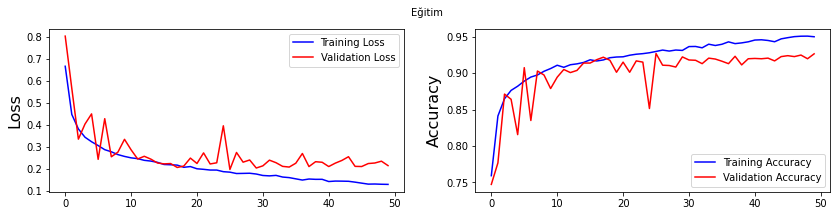

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()


In [ ]:
loss,acc = model.evaluate(X_test,  y_test, verbose=2)
print("başarım oranı: {:5.2f}%".format(100*acc))

75/75 - 1s - loss: 0.2508 - accuracy: 0.9178
başarım oranı: 91.78%


In [ ]:
labels =["0-18","18-65","65++"]
import matplotlib.pyplot as plt

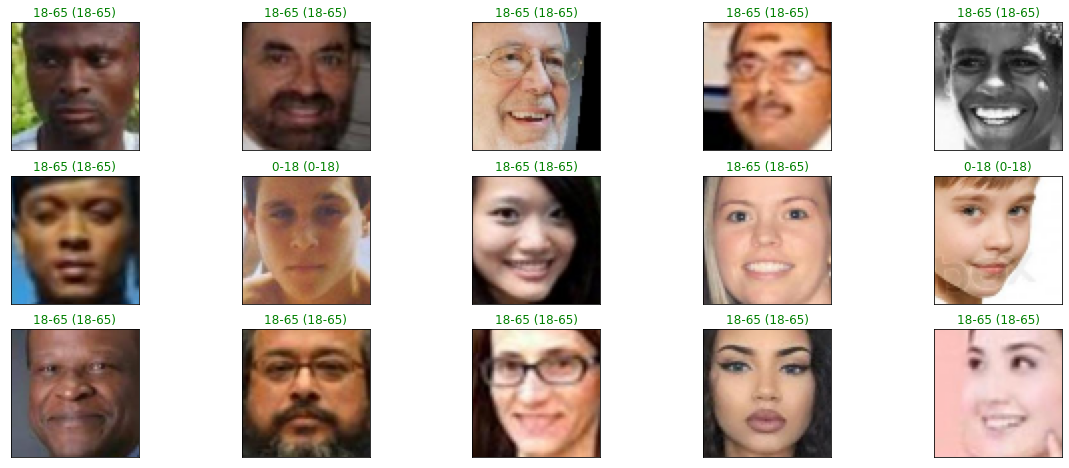

In [ ]:
Y = model.predict(X_test)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(Y[index])
    true_index = np.argmax(y_test[index])
    
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()

In [ ]:
import json
from keras.models import load_model
from keras.models import model_from_json
from keras.preprocessing import image

model_json = model.to_json()
with open("age3lu.json",'w') as json_file:
  json_file.write(model_json)

model.save('age3lu.h5')